# Data Preprocessing - Home Credit Default Risk (Selected Features)

## Goal
This notebook shows how to clean and prepare data for machine learning using only the most important features.

## Steps:
1. Load data and select important features
2. Handle missing values
3. Encode categorical variables
4. Scale numerical features
5. Save processed data

---


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import json
import os

# Settings
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("Set2")
pd.set_option('display.max_columns', None)

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")


Libraries imported successfully!
Pandas version: 2.3.2
NumPy version: 2.3.3


## 1. Load Data and Select Important Features


In [2]:
# Load data
print("Loading data...")

# Load training data
train_df = pd.read_csv('../data_raw/application_train.csv')
print(f"Training data loaded: {train_df.shape}")

# Load test data
test_df = pd.read_csv('../data_raw/application_test.csv')
print(f"Test data loaded: {test_df.shape}")

# Load column descriptions with proper encoding
try:
    columns_desc = pd.read_csv('../data_raw/HomeCredit_columns_description.csv', encoding='utf-8')
except UnicodeDecodeError:
    try:
        columns_desc = pd.read_csv('../data_raw/HomeCredit_columns_description.csv', encoding='latin-1')
    except UnicodeDecodeError:
        columns_desc = pd.read_csv('../data_raw/HomeCredit_columns_description.csv', encoding='cp1252')

print(f"Column descriptions loaded: {columns_desc.shape}")

# Load feature selection info
with open('../data_processed/feature_selection_info.json', 'r') as f:
    feature_selection_info = json.load(f)

selected_features = ['SK_ID_CURR', 'TARGET'] + feature_selection_info['selected_features']
print(f"Selected features: {len(selected_features) - 2} (excluding ID and target)")

# Filter data to selected features only
train_df = train_df[selected_features]
test_df = test_df[['SK_ID_CURR'] + feature_selection_info['selected_features']]

print(f"\nData overview after feature selection:")
print(f"Total records: {len(train_df):,}")
print(f"Number of features: {train_df.shape[1]}")
print(f"Target variable: {train_df['TARGET'].value_counts().to_dict()}")
print(f"Default rate: {train_df['TARGET'].mean()*100:.2f}%")

# Show feature categories
print(f"\nSelected features by category:")
for category, features in feature_selection_info['feature_categories'].items():
    available_in_category = [f for f in features if f in feature_selection_info['selected_features']]
    if available_in_category:
        print(f"  {category}: {len(available_in_category)} features")
        for feature in available_in_category:
            print(f"    - {feature}")


Loading data...
Training data loaded: (307511, 122)
Test data loaded: (48744, 121)
Column descriptions loaded: (219, 5)
Selected features: 40 (excluding ID and target)

Data overview after feature selection:
Total records: 307,511
Number of features: 42
Target variable: {0: 282686, 1: 24825}
Default rate: 8.07%

Selected features by category:
  demographics: 4 features
    - CODE_GENDER
    - DAYS_BIRTH
    - CNT_CHILDREN
    - CNT_FAM_MEMBERS
  financial: 4 features
    - AMT_INCOME_TOTAL
    - AMT_CREDIT
    - AMT_ANNUITY
    - AMT_GOODS_PRICE
  external_sources: 2 features
    - EXT_SOURCE_2
    - EXT_SOURCE_3
  employment: 4 features
    - DAYS_EMPLOYED
    - NAME_INCOME_TYPE
    - NAME_EDUCATION_TYPE
    - OCCUPATION_TYPE
  housing: 3 features
    - NAME_HOUSING_TYPE
    - FLAG_OWN_CAR
    - FLAG_OWN_REALTY
  family: 2 features
    - NAME_FAMILY_STATUS
    - NAME_TYPE_SUITE
  regional: 3 features
    - REGION_POPULATION_RELATIVE
    - REGION_RATING_CLIENT
    - REGION_RATING_CLIEN

## 2. Handle Missing Values


Missing values analysis:

Columns with missing values (17 out of 42):
                        Column  Missing_Count  Missing_Percent
15             OCCUPATION_TYPE          96391        31.345545
11                EXT_SOURCE_3          60965        19.825307
25   AMT_REQ_CREDIT_BUREAU_DAY          41519        13.501631
29  AMT_REQ_CREDIT_BUREAU_YEAR          41519        13.501631
24  AMT_REQ_CREDIT_BUREAU_HOUR          41519        13.501631
26  AMT_REQ_CREDIT_BUREAU_WEEK          41519        13.501631
27   AMT_REQ_CREDIT_BUREAU_MON          41519        13.501631
28   AMT_REQ_CREDIT_BUREAU_QRT          41519        13.501631
20             NAME_TYPE_SUITE           1292         0.420148
32    OBS_60_CNT_SOCIAL_CIRCLE           1021         0.332021
31    DEF_30_CNT_SOCIAL_CIRCLE           1021         0.332021
30    OBS_30_CNT_SOCIAL_CIRCLE           1021         0.332021
33    DEF_60_CNT_SOCIAL_CIRCLE           1021         0.332021
10                EXT_SOURCE_2            660   

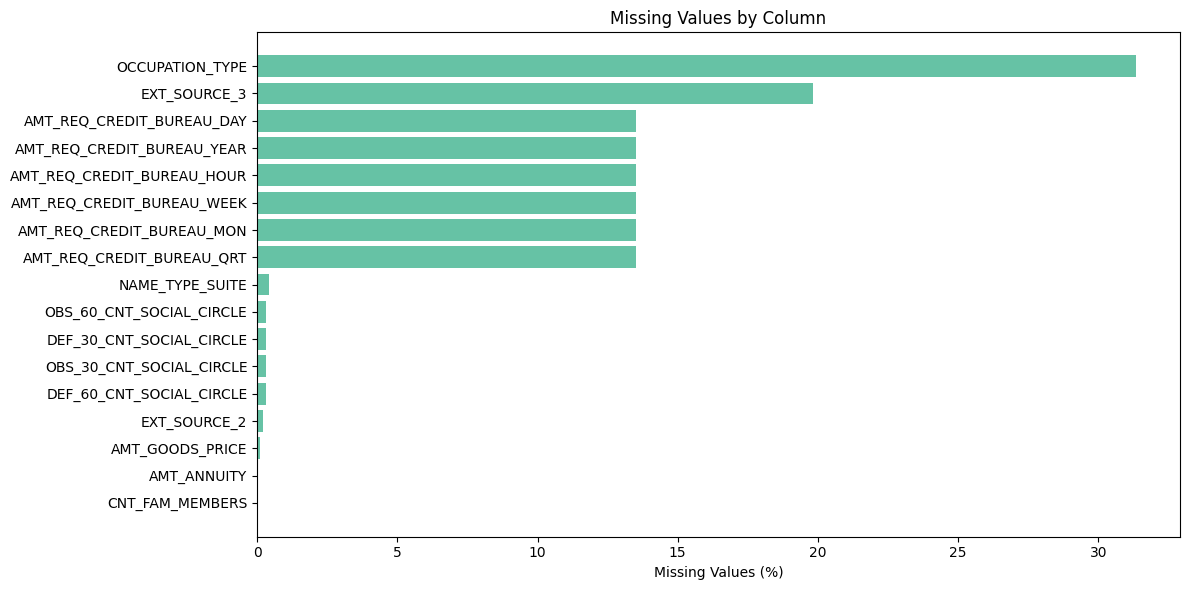

In [3]:
# Check missing values
print("Missing values analysis:")

# Count missing values
missing_data = train_df.isnull().sum()
missing_percent = (missing_data / len(train_df)) * 100

# Create DataFrame with missing values info
missing_df = pd.DataFrame({
    'Column': missing_data.index,
    'Missing_Count': missing_data.values,
    'Missing_Percent': missing_percent.values
})

# Sort by missing percentage
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Percent', ascending=False)

print(f"\nColumns with missing values ({len(missing_df)} out of {len(train_df.columns)}):")
print(missing_df)

# Plot missing values
if len(missing_df) > 0:
    plt.figure(figsize=(12, 6))
    plt.barh(range(len(missing_df)), missing_df['Missing_Percent'])
    plt.yticks(range(len(missing_df)), missing_df['Column'])
    plt.xlabel('Missing Values (%)')
    plt.title('Missing Values by Column')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("No missing values found!")


In [4]:
# Process missing values
print("Processing missing values...")

# Create copies for processing
train_processed = train_df.copy()
test_processed = test_df.copy()

# Function to handle missing values
def handle_missing_values(df, is_train=True):
    """
    Handle missing values in dataset
    """
    df_processed = df.copy()
    
    # Fill numerical columns with median
    numeric_cols = df_processed.select_dtypes(include=[np.number]).columns
    numeric_missing = [col for col in numeric_cols if df_processed[col].isnull().any()]
    
    if numeric_missing:
        print(f"Filling numerical columns with median: {len(numeric_missing)} columns")
        for col in numeric_missing:
            df_processed[col].fillna(df_processed[col].median(), inplace=True)
    
    # Fill categorical columns with mode
    categorical_cols = df_processed.select_dtypes(include=['object']).columns
    categorical_missing = [col for col in categorical_cols if df_processed[col].isnull().any()]
    
    if categorical_missing:
        print(f"Filling categorical columns with mode: {len(categorical_missing)} columns")
        for col in categorical_missing:
            mode_value = df_processed[col].mode()[0] if not df_processed[col].mode().empty else 'Unknown'
            df_processed[col].fillna(mode_value, inplace=True)
    
    return df_processed

# Process data
train_processed = handle_missing_values(train_processed, is_train=True)
test_processed = handle_missing_values(test_processed, is_train=False)

print(f"\nProcessing completed!")
print(f"Train size after processing: {train_processed.shape}")
print(f"Test size after processing: {test_processed.shape}")

# Check remaining missing values
remaining_missing_train = train_processed.isnull().sum().sum()
remaining_missing_test = test_processed.isnull().sum().sum()

print(f"\nRemaining missing values:")
print(f"Train: {remaining_missing_train}")
print(f"Test: {remaining_missing_test}")


Processing missing values...
Filling numerical columns with median: 15 columns
Filling categorical columns with mode: 2 columns
Filling numerical columns with median: 13 columns
Filling categorical columns with mode: 2 columns

Processing completed!
Train size after processing: (307511, 42)
Test size after processing: (48744, 41)

Remaining missing values:
Train: 0
Test: 0


## 3. Encode Categorical Variables


In [5]:
# Check categorical variables
print("Categorical variables analysis:")

categorical_cols = train_processed.select_dtypes(include=['object']).columns.tolist()
print(f"Found {len(categorical_cols)} categorical columns:")
for col in categorical_cols:
    unique_count = train_processed[col].nunique()
    print(f"  - {col}: {unique_count} unique values")

# Function to encode categorical variables
def encode_categorical_variables(df_train, df_test):
    """
    Encode categorical variables using LabelEncoder
    """
    df_train_encoded = df_train.copy()
    df_test_encoded = df_test.copy()
    
    categorical_cols = df_train_encoded.select_dtypes(include=['object']).columns.tolist()
    label_encoders = {}
    
    print(f"\nEncoding {len(categorical_cols)} categorical columns...")
    
    for col in categorical_cols:
        if col in df_train_encoded.columns and col in df_test_encoded.columns:
            # Create LabelEncoder
            le = LabelEncoder()
            
            # Combine unique values from train and test for fitting
            all_values = pd.concat([df_train_encoded[col], df_test_encoded[col]]).astype(str)
            le.fit(all_values)
            
            # Apply encoding
            df_train_encoded[col] = le.transform(df_train_encoded[col].astype(str))
            df_test_encoded[col] = le.transform(df_test_encoded[col].astype(str))
            
            label_encoders[col] = le
            print(f"  Done {col}: {len(le.classes_)} classes")
    
    return df_train_encoded, df_test_encoded, label_encoders

# Apply encoding
train_encoded, test_encoded, encoders = encode_categorical_variables(train_processed, test_processed)

print(f"\nEncoding completed!")
print(f"Train size after encoding: {train_encoded.shape}")
print(f"Test size after encoding: {test_encoded.shape}")


Categorical variables analysis:
Found 10 categorical columns:
  - CODE_GENDER: 3 unique values
  - NAME_INCOME_TYPE: 8 unique values
  - NAME_EDUCATION_TYPE: 5 unique values
  - OCCUPATION_TYPE: 18 unique values
  - NAME_HOUSING_TYPE: 6 unique values
  - FLAG_OWN_CAR: 2 unique values
  - FLAG_OWN_REALTY: 2 unique values
  - NAME_FAMILY_STATUS: 6 unique values
  - NAME_TYPE_SUITE: 7 unique values
  - WEEKDAY_APPR_PROCESS_START: 7 unique values

Encoding 10 categorical columns...
  Done CODE_GENDER: 3 classes
  Done NAME_INCOME_TYPE: 8 classes
  Done NAME_EDUCATION_TYPE: 5 classes
  Done OCCUPATION_TYPE: 18 classes
  Done NAME_HOUSING_TYPE: 6 classes
  Done FLAG_OWN_CAR: 2 classes
  Done FLAG_OWN_REALTY: 2 classes
  Done NAME_FAMILY_STATUS: 6 classes
  Done NAME_TYPE_SUITE: 7 classes
  Done WEEKDAY_APPR_PROCESS_START: 7 classes

Encoding completed!
Train size after encoding: (307511, 42)
Test size after encoding: (48744, 41)


## 4. Scale Numerical Features


In [6]:
# Prepare data for scaling
print("Preparing data for scaling...")

# Exclude ID and target variable from scaling
exclude_cols = ['SK_ID_CURR', 'TARGET']
feature_cols = [col for col in train_encoded.columns if col not in exclude_cols]

print(f"Number of features to scale: {len(feature_cols)}")

# Separate numerical and categorical features
numeric_features = train_encoded[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
print(f"Numerical features: {len(numeric_features)}")

# Function to scale features
def scale_features(df_train, df_test, feature_cols):
    """
    Scale numerical features
    """
    df_train_scaled = df_train.copy()
    df_test_scaled = df_test.copy()
    
    # Initialize StandardScaler
    scaler = StandardScaler()
    
    # Fit on train data
    df_train_scaled[feature_cols] = scaler.fit_transform(df_train[feature_cols])
    
    # Apply to test data
    df_test_scaled[feature_cols] = scaler.transform(df_test[feature_cols])
    
    return df_train_scaled, df_test_scaled, scaler

# Apply scaling
train_scaled, test_scaled, scaler = scale_features(train_encoded, test_encoded, numeric_features)

print(f"\nScaling completed!")
print(f"Train size after scaling: {train_scaled.shape}")
print(f"Test size after scaling: {test_scaled.shape}")

# Check statistics after scaling
print(f"\nStatistics after scaling (first 5 numerical features):")
print(train_scaled[numeric_features[:5]].describe())


Preparing data for scaling...
Number of features to scale: 40
Numerical features: 40

Scaling completed!
Train size after scaling: (307511, 42)
Test size after scaling: (48744, 41)

Statistics after scaling (first 5 numerical features):
        CODE_GENDER    DAYS_BIRTH  CNT_CHILDREN  CNT_FAM_MEMBERS  \
count  3.075110e+05  3.075110e+05  3.075110e+05     3.075110e+05   
mean  -2.310625e-18  3.327301e-17 -4.815343e-17     2.458505e-16   
std    1.000002e+00  1.000002e+00  1.000002e+00     1.000002e+00   
min   -7.203700e-01 -2.106335e+00 -5.775378e-01    -1.265722e+00   
25%   -7.203700e-01 -8.352476e-01 -5.775378e-01    -1.676384e-01   
50%   -7.203700e-01  6.576450e-02 -5.775378e-01    -1.676384e-01   
75%    1.388015e+00  8.304332e-01  8.072731e-01     9.304455e-01   
max    3.496400e+00  1.958761e+00  2.573387e+01     1.959787e+01   

       AMT_INCOME_TOTAL  
count      3.075110e+05  
mean      -1.229253e-17  
std        1.000002e+00  
min       -6.036870e-01  
25%       -2.374210e

## 5. Save Processed Data


In [7]:
# Save processed data
print("Saving processed data...")

# Create directory for processed data
os.makedirs('../data_processed', exist_ok=True)

# Save train data
train_scaled.to_csv('../data_processed/train_processed_selected.csv', index=False)
print("train_processed_selected.csv saved")

# Save test data
test_scaled.to_csv('../data_processed/test_processed_selected.csv', index=False)
print("test_processed_selected.csv saved")

# Save feature information
feature_info = {
    'total_features': len(feature_cols),
    'numeric_features': len(numeric_features),
    'categorical_features': len(categorical_cols),
    'feature_names': feature_cols,
    'numeric_feature_names': numeric_features,
    'categorical_feature_names': categorical_cols,
    'selected_features_info': feature_selection_info
}

with open('../data_processed/feature_info_selected.json', 'w') as f:
    json.dump(feature_info, f, indent=2)
print("feature_info_selected.json saved")

print(f"\nFinal statistics:")
print(f"Original train size: {train_df.shape}")
print(f"Processed train size: {train_scaled.shape}")
print(f"Original test size: {test_df.shape}")
print(f"Processed test size: {test_scaled.shape}")
print(f"Number of features: {len(feature_cols)}")
print(f"Target variable (default): {train_scaled['TARGET'].mean()*100:.2f}%")

print(f"\nData preprocessing completed successfully!")
print(f"Processed data saved in: ../data_processed/")
print(f"Features reduced from 81 to {len(feature_cols)} ({(1-len(feature_cols)/81)*100:.1f}% reduction)")


Saving processed data...
train_processed_selected.csv saved
test_processed_selected.csv saved
feature_info_selected.json saved

Final statistics:
Original train size: (307511, 42)
Processed train size: (307511, 42)
Original test size: (48744, 41)
Processed test size: (48744, 41)
Number of features: 40
Target variable (default): 8.07%

Data preprocessing completed successfully!
Processed data saved in: ../data_processed/
Features reduced from 81 to 40 (50.6% reduction)
